<a href="https://colab.research.google.com/github/mehdimerbah/TDA-PPIN/blob/main/preprocessing/DataPreprocessing_PPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Installation and Data Loading


Main packages to analyse the persistent homology of the network dataset are: ripser, persim and NetworkX.    
**ripser**: A lean python package for analysing persistent homology. (Builds on c++ Ripser library).   
**persim**: A python package for analyzing persistence diagrams generated from ripser.   
**NetworkX**: NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.


In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00


In [ ]:
! pip3 install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.1 MB/s eta 0:00:00


In [ ]:
## The following is the link to the CORUM DB remote server, but it seems to be down for the moment.
! wget http://mips.helmholtz-muenchen.de/corum/download/coreComplexes.txt.zip

--2023-10-26 13:48:14--  http://mips.helmholtz-muenchen.de/corum/download/coreComplexes.txt.zip
Resolving mips.helmholtz-muenchen.de (mips.helmholtz-muenchen.de)... 146.107.240.10
Connecting to mips.helmholtz-muenchen.de (mips.helmholtz-muenchen.de)|146.107.240.10|:80... ^C


In [ ]:
import pandas as pd
import numpy as np
import networkx as nwx
from ripser import ripser
import persim
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from igraph import Graph
from IPython.display import SVG, display
import matplotlib.pyplot as plt
#from pyvis.network import Network

We are fetching the raw data directly from the GCN study repository (temporarily). We should update these datasets from the original sources as new data became available for both the PPI network and the CORUM Human complexes.


In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/CORUM-Human-Complexes_r.txt

--2023-10-27 22:00:42--  https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/CORUM-Human-Complexes_r.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71159 (69K) [text/plain]
Saving to: ‘CORUM-Human-Complexes_r.txt’

CORUM-Human-Complex 100%[===================>]  69.49K  --.-KB/s    in 0.01s   

2023-10-27 22:00:43 (5.38 MB/s) - ‘CORUM-Human-Complexes_r.txt’ saved [71159/71159]



In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/GOSemSim_Wang_combined_BIOGRID-ORGANISM-Homo_sapiens.txt -O Human_PPI_Network.txt

--2023-10-27 22:00:44--  https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/GOSemSim_Wang_combined_BIOGRID-ORGANISM-Homo_sapiens.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8284541 (7.9M) [text/plain]
Saving to: ‘Human_PPI_Network.txt’

Human_PPI_Network.t 100%[===================>]   7.90M  --.-KB/s    in 0.1s    

2023-10-27 22:00:45 (81.6 MB/s) - ‘Human_PPI_Network.txt’ saved [8284541/8284541]



# Exploring PPI Network Data

In [ ]:
ppi_df = pd.read_table("Human_PPI_Network.txt", header=None)

In [ ]:
ppi_df.columns = ["ProteinA", "ProteinB", "SemSim"]

In [ ]:
ppi_df.sort_values(by=['SemSim'], ascending=False)

,ProteinA,ProteinB,SemSim
193691,ND4,NDUFS6,1.0
73921,MRPL4,MRPL2,1.0
298878,EFTUD2,FRG1,1.0
124168,KRTAP12-2,KRTAP5-9,1.0
124169,KRTAP12-1,KRTAP5-9,1.0
...,...,...,...
137465,CCDC101,ACTG1,0.0
137464,CCDC101,TADA2B,0.0
137463,CCDC101,SF3B5,0.0
137462,CCDC101,TAF12,0.0


## Testing NetworkX Package on PPI Data

In [ ]:
#subset_df = ppi_df.loc[0:100]
#subset_df.loc[:,['i-Factor']] = subset_df.loc[:,['i-Factor']]*10
subset_df = ppi_df[ppi_df['ProteinA'] == 'MAP2K4']
subset_df.sort_values(by=['SemSim'], ascending=False)

,ProteinA,ProteinB,SemSim
14986,MAP2K4,SPAG9,0.743667
51939,MAP2K4,BLNK,0.703000
258906,MAP2K4,UBC,0.688333
94343,MAP2K4,ARRB1,0.646000
18824,MAP2K4,MAPK8IP3,0.589000
22656,MAP2K4,NPHS1,0.405333


In [ ]:
n_subset_df = ppi_df[ppi_df['ProteinB'] == 'MAP2K4']
n_subset_df.sort_values(by=['SemSim'], ascending=False)

In [ ]:
G_0 = nwx.from_pandas_edgelist(
    n_subset_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)


In [ ]:
nwx.degree(G_0)

DegreeView({'FLNC': 1, 'MAP2K4': 35, 'MAPK8': 1, 'MAP4K2': 1, 'MAP2K7': 1, 'MAP3K8': 1, 'AKT1': 1, 'MAP3K11': 1, 'MAP3K4': 1, 'ARRB2': 1, 'MAP3K2': 1, 'MAP3K1': 1, 'ITCH': 1, 'MAPK9': 1, 'PML': 1, 'MAPK10': 1, 'MAP3K5': 1, 'MAP2K6': 1, 'MAPK14': 1, 'MAP3K3': 1, 'LRRK2': 1, 'APP': 1, 'JUN': 1, 'MAP3K7': 1, 'MAPK1': 1, 'GCH1': 1, 'GEMIN5': 1, 'RBBP8': 1, 'EGFR': 1, 'MAP3K10': 1, 'NBR1': 1, 'KTI12': 1, 'VASP': 1, 'FLNB': 1, 'CDC5L': 1, 'TRIM25': 1})

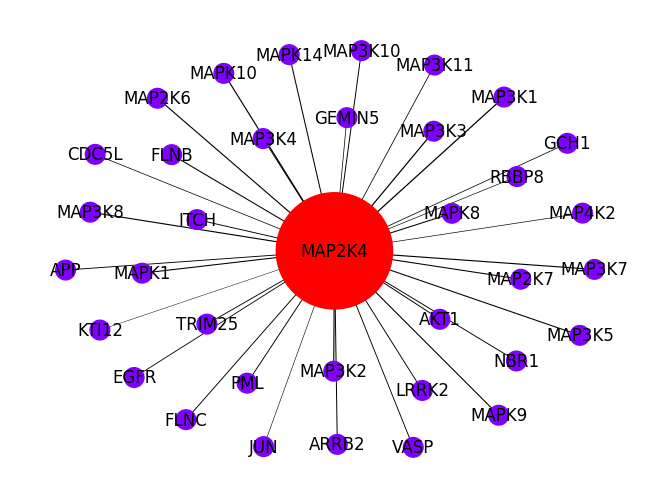

In [ ]:
scaled_degree = [d[1] * 200 for d in nwx.degree(G_0)]
nwx.draw(G_0,
        # Weights Based on Column
        width=list(nwx.get_edge_attributes(G_0, 'SemSim').values()),
        # Node size based on degree
        node_size=scaled_degree,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=True)


# Exploring Protein Complexes Data
This data was collected from the CORUM database. These are from the 3.0 database and were downloaded directly from the Github repository for the study. We should refer to the latest CORUM 4.0 update for a more comprehensive list of complexes.


In [ ]:
complexes_list = []
with open("/content/CORUM-Human-Complexes_r.txt") as complexes:
  for line in complexes:
    line = line.strip()
    temp_list = list(line.split("\t"))
    complexes_list.append(temp_list)

print(complexes_list)

[['BCL6', 'HDAC4'], ['BCL6', 'HDAC5'], ['BCL6', 'HDAC7'], ['NCOA3', 'EP300', 'KAT2B', 'CREBBP'], ['NCAPG', 'SMC2', 'SMC4', 'NCAPD2', 'NCAPH'], ['HPS4', 'HPS1'], ['HPS5', 'HPS6', 'HPS3'], ['CDS1', 'MUS81'], ['HDAC3', 'TBL1X', 'TBL1XR1', 'GPS2', 'CORO2A', 'NCOR1'], ['BLOC1S6', 'BLOC1S5', 'BLOC1S4', 'BLOC1S3', 'BLOC1S2', 'BLOC1S1', 'DTNBP1', 'SNAPIN'], ['ARPC3', 'ARPC1B', 'ARPC5', 'ARPC4', 'ARPC2', 'ACTR3', 'ACTR2'], ['PSME2', 'PSME1'], ['PSMD1', 'PSMD9', 'PSMD8', 'PSMD5', 'PSMD14', 'PSMD7', 'PSMD6', 'PSMD11', 'PSMD10', 'PSMD3', 'PSMD12', 'PSMD2', 'PSMD13', 'PSMD4', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6'], ['PFDN1', 'PFDN2', 'PFDN5', 'VBP1', 'PFDN6', 'PFDN4'], ['AP1M2', 'AP1G1', 'AP1G2', 'AP1M1', 'AP1S1', 'AP1S2', 'AP1S3', 'AP1B1'], ['HDAC1', 'BCL6', 'MBD3', 'MTA2', 'MTA3'], ['PSENEN', 'PSEN1', 'APH1A', 'NCSTN'], ['HDAC1', 'DNMT3B', 'SMC2', 'SMC4', 'KIF4A', 'SMARCA5', 'SIN3A'], ['RABGEF1', 'RAB5A', 'RABEP1'], ['HDAC1', 'HDAC2', 'SAP30', 'RBBP7', 'RBBP4', 'SAP18', 'SIN3A'], [

In [ ]:
print(len(complexes_list))
## We have 2645 protein complexes

2645


In [ ]:
# Check the largest complex
largest_idx = 0
for idx, cmplx in enumerate(complexes_list):
  if len(cmplx) > len(complexes_list[largest_idx]):
    largest_idx = idx
print(largest_idx)
# The largest Protein Complex includes 171 individual proteins.

171


## Testing NetworkX Package on Complexes Data

In [ ]:
test_complex = complexes_list[15]
test_complex_ppi_df = ppi_df[(ppi_df['ProteinA'].isin(test_complex)) & (ppi_df['ProteinB'].isin(test_complex)) ]
test_complex_ppi_df.sort_values(by='SemSim')


In [ ]:
test_G = nwx.from_pandas_edgelist(
    test_complex_ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

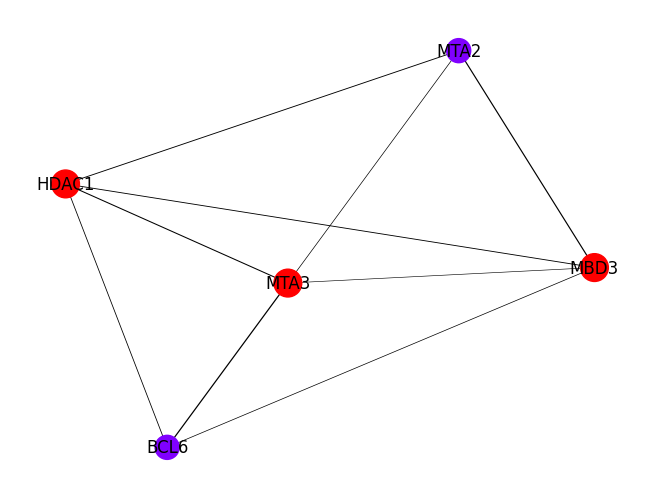

In [ ]:
scaled_degree = [d[1]*100 for d in nwx.degree(test_G)]
nwx.draw(test_G,
        # Weights Based on Column
        width=list(nwx.get_edge_attributes(test_G, 'SemSim').values()),
        # Node size based on degree
        node_size=scaled_degree,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=True)

## Distance Matrix Generation and Persistent Homology Testing with Ripser

We generate a distance matrix. Using distance as a metric measure is a way of interpresting the graph topological space as a metric space. This should give us a good measure of node distances as measured by shortest path (Floyd-Warshall)

In [ ]:
D = np.array(nwx.floyd_warshall_numpy(test_G))

In [ ]:
D

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 2., 1.],
       [1., 1., 0., 1., 1.],
       [1., 2., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

We can now use ripser to generate some persistence diagrams.

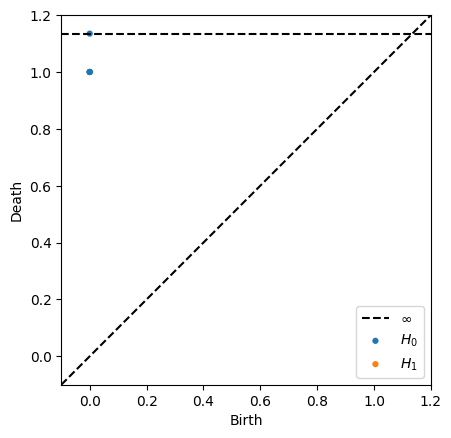

In [ ]:
diag = ripser(D,distance_matrix=True)['dgms']
persim.plot_diagrams(diag)

We should now cluster the components to identify the protein sub-communities/hubs that have potential to form a complex.

In [ ]:
threshold = 0.2

complexes = []
for i, dgm in enumerate(diag):
    for pt in dgm:
        if pt[1] - pt[0] > threshold:
            complex_nodes = [node for node in test_G.nodes if test_G.nodes[node]['component'] == i]
            complexes.append(complex_nodes)

# Visualize the identified complexes
for i, complex_nodes in enumerate(complexes):
    print(f'Complex {i + 1}: {complex_nodes}')


In [ ]:
for i, dgm in enumerate(diag):
  print(i, end=" ")
  print(dgm)

0 [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0. inf]]
1 []


# Adjacency Matrix Data Transformation
We can exploit the vietoris rips packages used for feature extraction for the NN models, but we need to wrangle the graph into and adjacency matrix. This would enable us to feed it into the giotto-tda package.   
We should also generate these matrices to feed into the GCN models.


## Checking Common Proteins

In [ ]:
## We should first explore the individual files proteins:
## Get unique proteins from the Complexes file
## Check common proteins
complexes_dict = {}
complexes_single_proteins = []
for idx, cmplx in enumerate(complexes_list):
  for protein in cmplx:
    if protein not in complexes_single_proteins:
      complexes_single_proteins.append(protein)

  complexes_dict[idx] = cmplx


In [ ]:
## Get unique proteins from the known complexes
print(complexes_single_proteins)
print(len(complexes_single_proteins))
print(complexes_dict)

['BCL6', 'HDAC4', 'HDAC5', 'HDAC7', 'NCOA3', 'EP300', 'KAT2B', 'CREBBP', 'NCAPG', 'SMC2', 'SMC4', 'NCAPD2', 'NCAPH', 'HPS4', 'HPS1', 'HPS5', 'HPS6', 'HPS3', 'CDS1', 'MUS81', 'HDAC3', 'TBL1X', 'TBL1XR1', 'GPS2', 'CORO2A', 'NCOR1', 'BLOC1S6', 'BLOC1S5', 'BLOC1S4', 'BLOC1S3', 'BLOC1S2', 'BLOC1S1', 'DTNBP1', 'SNAPIN', 'ARPC3', 'ARPC1B', 'ARPC5', 'ARPC4', 'ARPC2', 'ACTR3', 'ACTR2', 'PSME2', 'PSME1', 'PSMD1', 'PSMD9', 'PSMD8', 'PSMD5', 'PSMD14', 'PSMD7', 'PSMD6', 'PSMD11', 'PSMD10', 'PSMD3', 'PSMD12', 'PSMD2', 'PSMD13', 'PSMD4', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PFDN1', 'PFDN2', 'PFDN5', 'VBP1', 'PFDN6', 'PFDN4', 'AP1M2', 'AP1G1', 'AP1G2', 'AP1M1', 'AP1S1', 'AP1S2', 'AP1S3', 'AP1B1', 'HDAC1', 'MBD3', 'MTA2', 'MTA3', 'PSENEN', 'PSEN1', 'APH1A', 'NCSTN', 'DNMT3B', 'KIF4A', 'SMARCA5', 'SIN3A', 'RABGEF1', 'RAB5A', 'RABEP1', 'HDAC2', 'SAP30', 'RBBP7', 'RBBP4', 'SAP18', 'MAPK3', 'MAPK1', 'NCOR2', 'AP3B1', 'AP3B2', 'AP3M1', 'AP3M2', 'AP3S2', 'AP3S1', 'AP3D1', 'IRF9', 'STAT2', '

In [ ]:
## Get unique proteins from the PPI Network file
ppi_single_proteins_m = ppi_df['ProteinA'].unique()
len(ppi_single_proteins_m)

15348

In [ ]:
ppi_single_proteins_n = ppi_df['ProteinB'].unique()
len(ppi_single_proteins_n)

15429

In [ ]:
ppi_single_proteins = set(ppi_single_proteins_m).union(set(ppi_single_proteins_n))

In [ ]:
len(ppi_single_proteins)

17739

In [ ]:
## PPI proteins existing in the complexes
common_proteins = ppi_single_proteins.intersection(complexes_single_proteins)

In [ ]:
len(common_proteins)

3544

## Adjacency Matrix Transformation

### Approach 1

In [ ]:
common_proteins_indices = {}
for idx, protein in enumerate(common_proteins):
  common_proteins_indices[protein] = idx


NameError: ignored

In [ ]:
print(common_proteins)

{'ASB2', 'FOSB', 'PRMT5', 'RFX5', 'NDUFB5', 'SOX2', 'FILIP1', 'DPF2', 'DPM1', 'KIN', 'SIKE1', 'BAK1', 'KCNJ11', 'CALM1', 'EXO1', 'SSTR2', 'KEAP1', 'PMS1', 'DLG1', 'TINF2', 'EPB41', 'POLD4', 'KANSL1', 'STT3A', 'NGFR', 'BOLA2', 'PRUNE', 'VPS16', 'ATF7', 'ARPC1B', 'WAS', 'VDAC2', 'CEBPA', 'SEMA3A', 'SNRPN', 'RAP1A', 'PSMD10', 'STX4', 'TUBB3', 'IPO4', 'ZNF304', 'RPP14', 'POLR1B', 'CABIN1', 'KLHL24', 'NCAPD3', 'MEAF6', 'GTF2F1', 'AHNAK', 'VAMP8', 'NDUFV2', 'EIF2S3', 'PLXNA1', 'STAT1', 'AP4B1', 'KCNQ2', 'TYK2', 'DHX30', 'MRPL2', 'MAX', 'PRPF3', 'SPTAN1', 'IL13RA1', 'IFNA2', 'TFPI2', 'MRPL44', 'STAT2', 'LIF', 'SF3B4', 'VAPA', 'SIX1', 'DARS', 'SNRPB', 'SNCAIP', 'SF3A1', 'STRN3', 'PSMD5', 'NCOA2', 'AP4E1', 'ITGB1', 'KPNA3', 'ARRB1', 'SQSTM1', 'SIAH2', 'XAB2', 'LRRC8A', 'MSH5', 'PTCH1', 'IQCB1', 'PSMC3', 'CAPG', 'CD44', 'ACTR8', 'HERC1', 'NEDD9', 'WDR20', 'LITAF', 'GABPB2', 'PTBP1', 'RALBP1', 'MRPL54', 'IL12B', 'RAPGEF1', 'SMARCC1', 'INTS6', 'THBS1', 'EPRS', 'ARHGEF6', 'POLR1D', 'GRIA1', 'BLOC1S

In [ ]:
common_proteins_neighbors = {}

for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  common_proteins_neighbors[protein] = list(set(neighbors) & set(common_proteins))

  #for neighbor in neighbors:
   # common_proteins_neighbors[protein]  = list.append((common_proteins_indices[neighbor], ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']))

In [ ]:
m = 3544
adjacency_mat = [[0] * m] * m

In [ ]:
for protein in common_proteins_neighbors:
  neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = 1

In [ ]:
for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  #neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    if neighbor in common_proteins:
      adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']

### Approach 2
The previous approach is very computationally costly, as such we will try to optimize it to a more basic one.

In [ ]:
ppi_unique_proteins = np.unique(ppi_df[['ProteinA', 'ProteinB']])

In [ ]:
protein_to_idx = {protein: idx for idx, protein in enumerate(ppi_unique_proteins)}

In [ ]:
## We get 17739 unique proteins from the PPI Network dataset
n_proteins = len(ppi_unique_proteins)

In [ ]:
adj_mat = np.matrix(np.ones((n_proteins, n_proteins)) * np.inf)

In [ ]:
for idx, row in ppi_df.iterrows():
  protein_A = protein_to_idx[row['ProteinA']]
  protein_B = protein_to_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  adj_mat[protein_A, protein_B] = sem_sim_score
  adj_mat[protein_B, protein_A] = sem_sim_score

In [ ]:
## We get the following very sparse adjacency matrix
adj_mat

matrix([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]])

In [ ]:
np.fill_diagonal(adj_mat, 1)
adj_mat

matrix([[ 1., inf, inf, ..., inf, inf, inf],
        [inf,  1., inf, ..., inf, inf, inf],
        [inf, inf,  1., ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ...,  1., inf, inf],
        [inf, inf, inf, ..., inf,  1., inf],
        [inf, inf, inf, ..., inf, inf,  1.]])

In [ ]:
np.savetxt('ppi_adj_mat.tsv',adj_mat,delimiter='  ')

In [ ]:
## In the interest of saving memory, converting the matrix to sparse row format with scipy might be a good idea
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
adj_mat_sparse = csr_matrix(adj_mat)

In [ ]:
## save_npz exports the matrix to an npz file, to load it back, use the load_npz method.
save_npz('sparse_matrix.npz', adj_mat_sparse)

# Testing giotto-tda Persistent Homology Package

## Full PPI Dataset testing
This has flooded the memory, so while waiting for the access to the cluster to use the full network I will work on a subset in the next section.

In [ ]:
## The matrix is too large and overflows the memory
VR = SparseRipsPersistence(metric='precomputed')
mats = [np.asarray(adj_mat)]

In [ ]:
dgms = VR.fit_transform(mats)

ValueError: ignored

## PPI Subset testing

### Extracting Data Subset

In [ ]:
complexes_proteins_df = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins)) & (ppi_df['ProteinB'].isin(complexes_single_proteins))]

In [ ]:
complexes_proteins_df.to_csv("/complexes_proteins_data.csv")

In [ ]:
complexes_proteins_idx = {protein: idx for idx, protein in enumerate(complexes_single_proteins)}

In [ ]:
c_proteins = len(complexes_single_proteins)

### Graph Visualization

In [ ]:
tmp_G = nwx.from_pandas_edgelist(
        complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )


In [ ]:
tmp_G.degree()

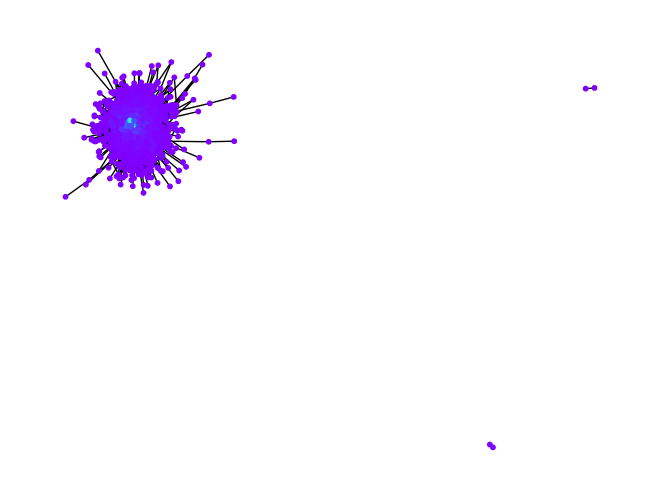

In [ ]:
scaled_degree = [d[1]*1000 for d in nwx.degree(tmp_G)]
nwx.draw_spring(tmp_G,
        # Weights Based on Column
        ##width=list(nwx.get_edge_attributes(tmp_G, 'SemSim').values()),
        # Colour Based on Degree
        node_color=scaled_degree,
        node_size=10,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

In [ ]:
net = Network(notebook=True)
net.from_nx(tmp_G)

net.show("test_plot.html")

### Node Degree Exploration

In [ ]:
## The following is just to check the distribution of the node degrees. As it seems like there are highly central nodes
degree_nodes = {}
for p, d in tmp_G.degree():
  degree_nodes[p] = d

## This gives that there are nodes with degree > 900
sorted_node_degrees = dict(sorted(degree_nodes.items(), key=lambda item: item[1],  reverse=True))


In [ ]:
## Let's visualize the distribution
viz_degree = {degree: 0 for degree in degree_nodes.values()}
for degree in degree_nodes.values():
  viz_degree[degree]+=1

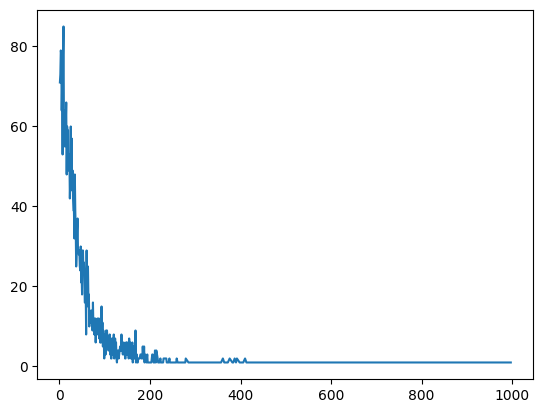

In [ ]:
degree_count_pairs = sorted(viz_degree.items())
x, y = zip(*degree_count_pairs) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

In [ ]:
## I will create another subgraph with nodes capped at a maximum degree of 200
capped_complexes_dict = {protein: degree for protein, degree in degree_nodes.items() if degree <= 200}
capped_complexes_dict

In [ ]:
capped_complexes_proteins = list(capped_complexes_dict.keys())

In [ ]:
## Create dataframe subset for the "low degree" proteins
capped_complexes_proteins_df = ppi_df[(ppi_df['ProteinA'].isin(capped_complexes_proteins)) & (ppi_df['ProteinB'].isin(capped_complexes_proteins))]

In [ ]:
capped_graph = nwx.from_pandas_edgelist(
        capped_complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )


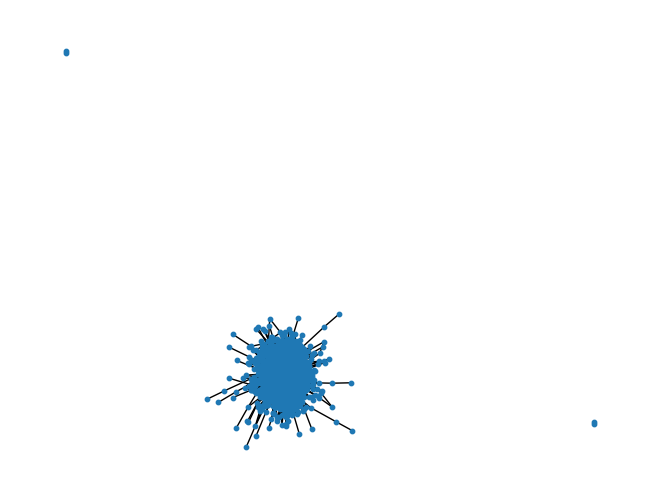

In [ ]:
pos = nwx.spring_layout(capped_graph)  # Define a layout for the nodes
#labels = {i: i for i in capped_graph.nodes()}  # Node labels
nwx.draw(capped_graph, pos, node_size=10)
edge_labels = nwx.get_edge_attributes(capped_graph, 'weight')  # Optional: Add edge weights as labels
#nwx.draw_networkx_edge_labels(capped_graph, pos, edge_labels=edge_labels)

# Display the graph
plt.show()

### Creating Adjacency Matrix

In [ ]:
complexes_adj_mat = np.matrix(np.ones((c_proteins, c_proteins)) * np.inf)

In [ ]:
for idx, row in complexes_proteins_df.iterrows():
  protein_A = complexes_proteins_idx[row['ProteinA']]
  protein_B = complexes_proteins_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  complexes_adj_mat[protein_A, protein_B] = sem_sim_score
  complexes_adj_mat[protein_B, protein_A] = sem_sim_score

In [ ]:
complexes_adj_mat

matrix([[       inf, 0.58133333, 0.61166667, ...,        inf,        inf,
                inf],
        [0.58133333,        inf, 0.86866667, ...,        inf,        inf,
                inf],
        [0.61166667, 0.86866667,        inf, ...,        inf,        inf,
                inf],
        ...,
        [       inf,        inf,        inf, ...,        inf,        inf,
                inf],
        [       inf,        inf,        inf, ...,        inf,        inf,
                inf],
        [       inf,        inf,        inf, ...,        inf,        inf,
                inf]])

In [ ]:
np.fill_diagonal(complexes_adj_mat, 1)

In [ ]:
complexes_adj_mat

NameError: ignored

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
complexes_adj_mat_sparse = csr_matrix(complexes_adj_mat)

In [ ]:
save_npz('sparse_matrix.npz', complexes_adj_mat_sparse)

### Vietoris Rips Persistence Filtration

In [ ]:
VR = VietorisRipsPersistence(metric='precomputed')
matrices = [np.asarray(complexes_adj_mat)]

In [ ]:
diags = VR.fit_transform(matrices)

In [ ]:
diags

array([[[0.        , 0.        , 0.        ],
        [0.97766668, 1.        , 1.        ],
        [0.94066668, 0.94599998, 1.        ],
        ...,
        [0.        ,        inf, 1.        ],
        [0.        ,        inf, 1.        ],
        [0.        ,        inf, 1.        ]]])

In [ ]:
VR.plot(diags, sample=0)

In [ ]:
print(f"diagrams.shape: {diags.shape} ({diags.shape[1]} topological features)")

diagrams.shape: (1, 22503, 3) (22503 topological features)


In [ ]:
diags.shape[1]

22503

In [ ]:
diags.shape

## Testing --ignore--

In [ ]:
tmp_G = nwx.from_pandas_edgelist(
        complexes_proteins_df,
        source='ProteinA',
        target='ProteinB',
        edge_attr='SemSim'
    )

In [ ]:
D = np.array(nwx.floyd_warshall_numpy(tmp_G))

In [ ]:
dgms = ripser(D,distance_matrix=True)['dgms']